# Notebook examples for Chapter 8
# Unsupervised Classification
Supervised classification of remote sensing imagery,
the subject of the preceding two Chapters, involves
the use of a training dataset consisting of labeled pixels
representative of each land cover category of interest in an image. The choice of
training areas which adequately represent the spectral
characteristics of each category is very important for supervised
classification, as the quality of the training set has a profound
effect on the validity of the  result. Finding and verifying
training areas can be laborious, since the analyst must select
representative pixels for each of the classes by visual
examination of the image  and by information extraction from
additional sources such as ground reference data (ground truth),
aerial photos or existing maps.
The subject of this Chapter, unsupervised
classification or _clustering_,
requires no reference information at
all.  Instead, the attempt is made to find an underlying
class structure automatically by organizing the data into groups
sharing similar (e.g.,  spectrally homogeneous) characteristics.
Often, one only needs to specify beforehand the number $K$ of
classes present. Unsupervised classification plays an especially important role
when very little _a priori_ information about the data is
available. A primary objective of using clustering algorithms
for multispectral remote sensing data  is often to
obtain useful information for the selection of training regions
in a subsequent supervised classification.

In [1]:
import ee
ee.Authenticate()
ee.Initialize()
%matplotlib inline

Enter verification code:  4/1Ab_5qlmVdWNF-hl1108GxMzTPtgd9Z-ONDHIpMFzKZSAMD8XcOIIbo1G0dI



Successfully saved authorization token.


## 8.1 Simple cost functions
## 8.2 Algorithms that minimize the simple cost functions

### 8.2.1 K-means clustering

#### 8.2.1.1 K-means with Scipy

In [2]:
%run scripts/kmeans -p [1,2,3,4] -k 8 imagery/AST_20070501_pca.tif

Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


------------ k-means ------------
Tue Apr 22 13:01:03 2025
Input imagery/AST_20070501_pca.tif
Number of clusters 8
Kmeans result written to: imagery/AST_20070501_pca_kmeans.tif
elapsed time: 23.947874307632446


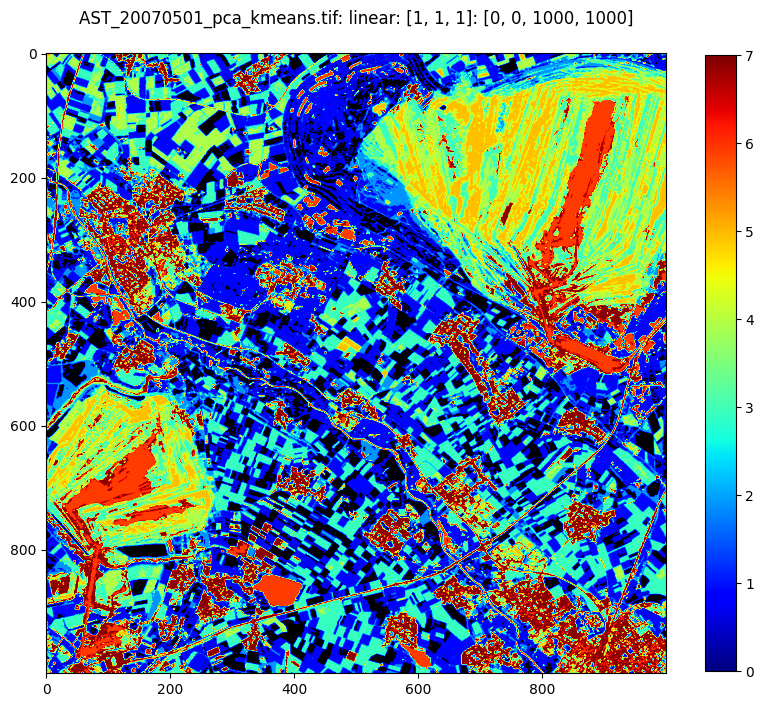

<Figure size 640x480 with 0 Axes>

In [3]:
%run scripts/dispms -f imagery/AST_20070501_pca_kmeans.tif -c \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter8/fig8_1.eps'

#### 8.2.1.2 K-means on GEE

In [ ]:
from ipyleaflet import (Map,DrawControl,TileLayer)

image = ee.Image('projects/ee-mortcanty/assets/CRC5/AST_20070501_pca').select(0,1,2,3)
region = image.geometry()

training = image.sample(region=region,scale=15,numPixels=100000)
clusterer = ee.Clusterer.wekaKMeans(8)
trained = clusterer.train(training)
clustered = image.cluster(trained)

In [ ]:
# function for overlaying tiles onto a map
def GetTileLayerUrl(ee_image_object):
  map_id = ee.Image(ee_image_object).getMapId()
  tile_fetcher = map_id['tile_fetcher']
  return tile_fetcher.url_format

# display the default base map and overlay the clustered image
center = list(reversed(region.centroid().getInfo()['coordinates']))
m = Map(center=center, zoom=11)
jet = 'black,blue,cyan,yellow,red'
m.add_layer(TileLayer(url=GetTileLayerUrl(
        clustered.select('cluster').visualize(min=0, max=6, palette= jet, opacity = 1.0)
    )
))

m

### 8.2.2 Kernel K-means clustering

In [4]:
run scripts/kkmeans -p [1,2,3,4] -n 1 -k 8 imagery/AST_20070501_pca.tif 

Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


    kernel k-means
infile: imagery/AST_20070501_pca.tif
samples: 1000 
clusters: 8
kernel matrix...
gamma: 0
iterations: 30
classifying...

result written to: imagery/AST_20070501_pca_kkmeans.tif
elapsed time: 3.8447771072387695


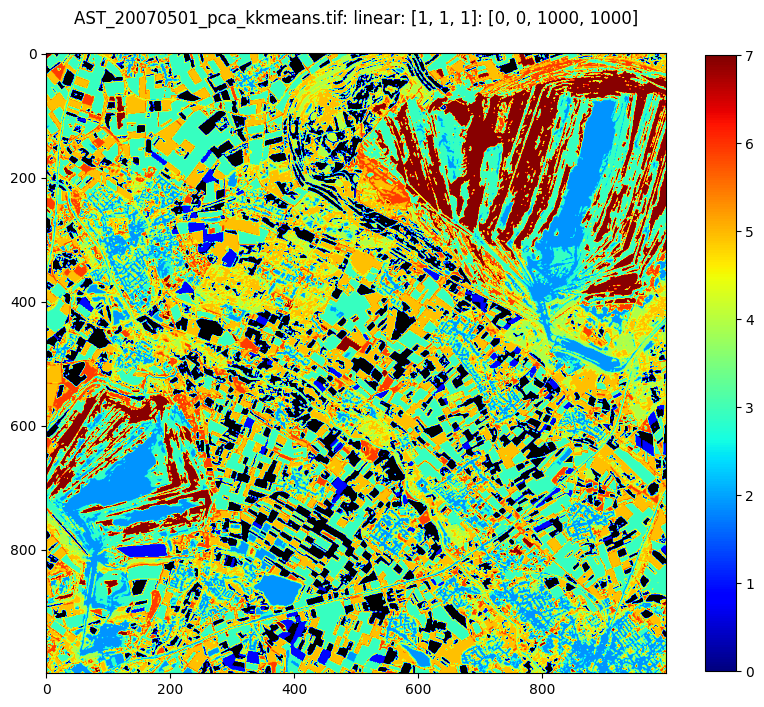

<Figure size 640x480 with 0 Axes>

In [5]:
%run scripts/dispms -f imagery/AST_20070501_pca_kkmeans.tif -c \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter8/fig8_2.eps'

### 8.2.3 Extended K-mean clustering

In [ ]:
run scripts/ekmeans -b 1 imagery/AST_20070501_pca.tif

In [ ]:
%run scripts/dispms -f imagery/AST_20070501_pca_ekmeans.tif -c \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter8/fig8_3.eps'

### 8.2.4 Agglomerative hierarchical clustering

In [ ]:
run scripts/hcl -h

In [ ]:
run scripts/hcl -p [1,2,3,4] -k 8 -s 2000 imagery/AST_20070501_pca.tif

In [ ]:
run scripts/dispms -f imagery/AST_20070501_pca_hcl.tif -c

### 8.2.5 Fuzzy K-means clustering

## 8.3 Gaussian mixture clustering
### 8.3.1 Expectation maximization
### 8.3.2 Simulated annealing
### 8.3.3 Partition density
### 8.3.4 Implementation notes
## 8.4 Including spatial information
### 8.4.1 Multi-resolution clustering
### 8.4.2 Spatial clustereing

In [ ]:
run scripts/em -h

In [ ]:
run scripts/em -p [1,2,3,4] -K 8 imagery/AST_20070501_pca.tif

In [ ]:
%run scripts/dispms -f imagery/AST_20070501_pca_em.tif -c  \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter8/fig8_5.eps'

## 8.5 A benchmark

In [ ]:
from osgeo.gdalconst import GDT_Float32

image = np.zeros((800,800,3))
b = 2.0
image[99:699 ,299:499 ,:] = b
image[299:499 ,99:699 ,:] = b
image[299:499 ,299:499 ,:] = 2*b
n1 = np.random.randn(800,800)
n2 = np.random.randn(800,800)
n3 = np.random.randn(800,800)
image[:,:,0] += n1
image[:,:,1] += n2+n1
image[:,:,2] += n3+n1/2+n2/2
driver = gdal.GetDriverByName('GTiff')    
outDataset = driver.Create('imagery/toy.tif',
                           800,800,3,GDT_Float32)  
for k in range(3):        
    outBand = outDataset.GetRasterBand(k+1)
    outBand.WriteArray(image[:,:,k],0,0) 
    outBand.FlushCache() 
outDataset = None                     

In [ ]:
run scripts/dispms -f 'imagery/toy.tif' -e 3 -p [1,2,3]

In [ ]:
run scripts/ex3_2 imagery/toy.tif

In [ ]:
run scripts/hcl -k 3 -s 2000 imagery/toy.tif

In [ ]:
run scripts/em -K 3 -s 1.0 imagery/toy.tif

In [ ]:
run scripts/dispms -f imagery/toy_em.tif -c -F imagery/toy_hcl.tif -C

## 8.6 The Kohonen self-organizing map

In [ ]:
run scripts/som -c 6  imagery/AST_20070501.tif

In [ ]:
%run scripts/dispms -f imagery/AST_20070501_som.tif -e 4 -p [1,2,3]  \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter8/fig8_9.eps'

## 8.7 Image segmentation and the mean shift

Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


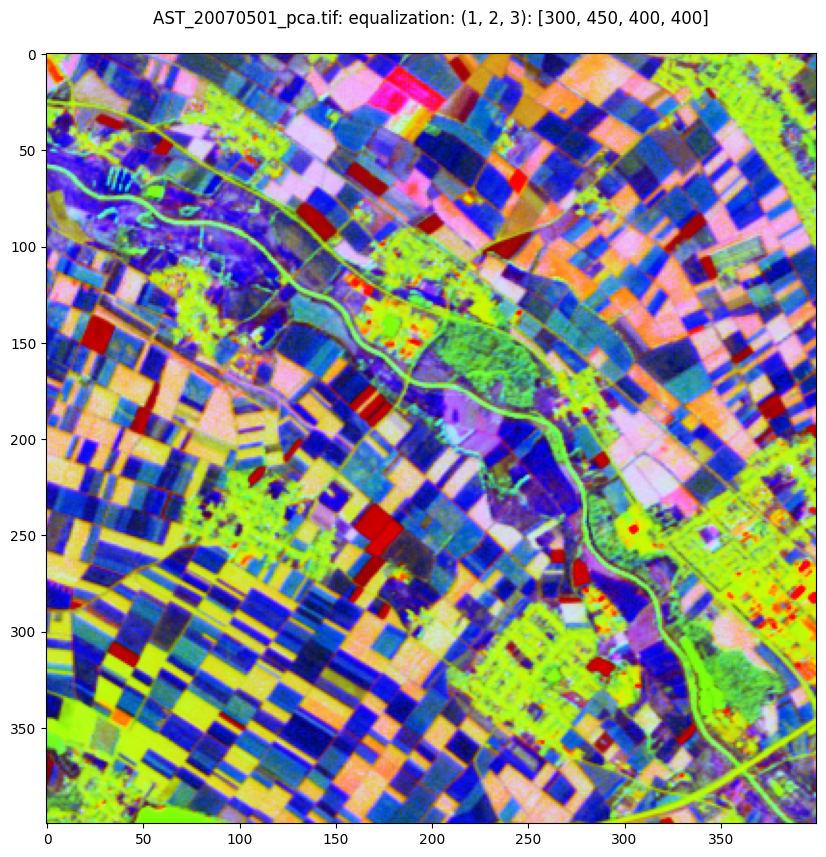

<Figure size 640x480 with 0 Axes>

In [6]:
run scripts/dispms -f imagery/AST_20070501_pca.tif -p [1,2,3] -e 4 -d [300,450,400,400]

In [7]:
run scripts/meanshift -p [1,2,3,4] -d [300,450,400,400] -s 30 -r 15 -m 10 imagery/AST_20070501_pca.tif

Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


    mean shift
infile: imagery/AST_20070501_pca.tif
filtering pixels...
result written to: imagery/AST_20070501_pca_meanshift.tif
elapsed time: 158.59595346450806


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


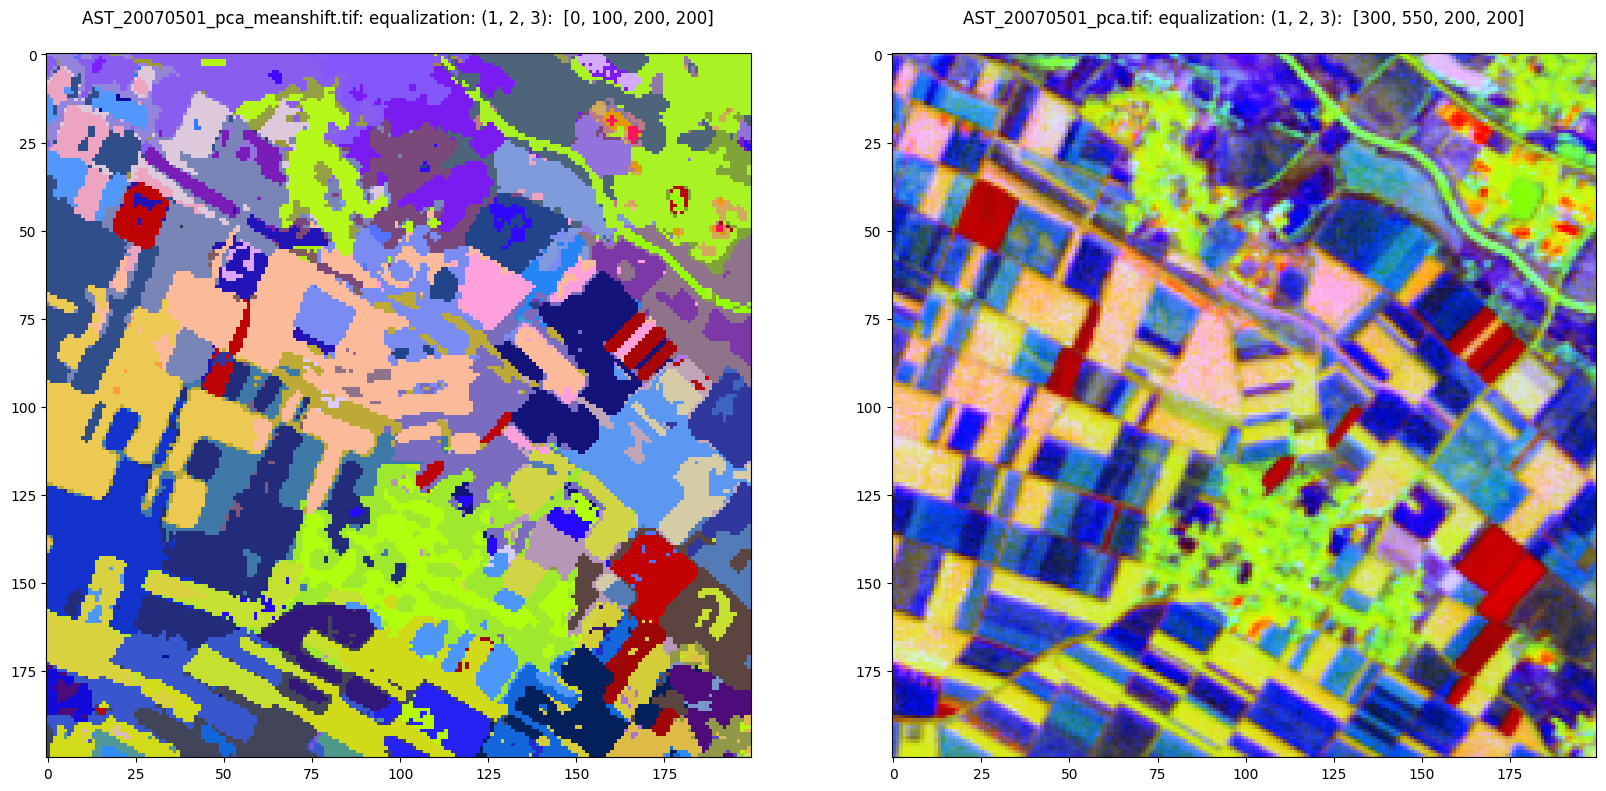

<Figure size 640x480 with 0 Axes>

In [8]:
%run scripts/dispms -f imagery/AST_20070501_pca_meanshift.tif -p [1,2,3] -e 4  -d [0,100,200,200]  \
-F imagery/AST_20070501_pca.tif -P [1,2,3] -E 4 -D [300,550,200,200] \
#-s  '/home/mort/LaTeX/new projects/CRC5/Chapter8/fig8_10.eps'